In [1]:
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
import glob
import csv
import os
import tarfile
import math
import numpy as np 
from tqdm import tqdm
import json
from progressive.bar import Bar
import pickle as pkl
import networkx as nx
from __future__ import unicode_literals

In [2]:
# with open('Bipartite_Drug_graph_Normalized.pkl','rb') as f:
#     drug_association_graph  = pkl.load(f)
    
with open('scratchpad/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('scratchpad/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [3]:
print len(drug_association_graph.edges()) 
print len(drug_cat_association_graph.edges())


print len(drug_association_graph.nodes()) 

print len(drug_cat_association_graph.nodes())

7954
33493
4029
4047


In [4]:
# drug_cat_association_graph.nodes(data=True)

In [5]:
files = glob.glob('../BL_Work/openPrescribe/uncompressed/*.tar.gz')
print files

[u'../BL_Work/openPrescribe/uncompressed/T201704PDPI BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201403ADDR BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201111CHEM SUBS.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201704ADDR BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201705ADDR BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201210ADDR BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201208CHEM SUBS.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201807ADDR BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201507PDPI BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201605PDPI BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201611ADDR BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201110CHEM SUBS.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201202PDPI BNFT.CSV.tar.gz', u'../BL_Work/openPrescribe/uncompressed/T201312PDPI BNFT.CSV.tar.gz', u'../BL_Work/openPr

In [6]:
#Different functions to extract different data form the prescription 

def cleanStringofUTF(string):
    cleaned = string.replace('\xe8','e').replace('\xf6','o')
    return cleaned

def enrichdrugs(chem_dict , drugs):
    diabetes_drug_words = [drugs[k]['name'].lower() for k in drugs]
    for drug in chem_dict:
        Name = chem_dict[drug]['name'].replace('(','').replace(')','')
        slot1 = Name.lower().split('/')
        slot2 = Name.lower().split(' ')
        slot3 = Name.lower().split(' & ')
        common1 = set(diabetes_drug_words).intersection(slot1)
        common2 = set(diabetes_drug_words).intersection(slot2)
        common3 = set(diabetes_drug_words).intersection(slot3)
        
        if len(common1) > 0 or len(common2) > 0 or len(common3) > 0:
            print common1 , common2 , common3
            drugs[chem_dict[drug]['code']] = {'disease':'' , 'disease_given_drug':0.0 , 'matched_disease':'', 'name':chem_dict[drug]['name'].strip() }

            
            
def makeChemDict(BNF_Chem):
    chem_dict = {}
    for index, row in BNF_Chem.iterrows():
        chem_dict[row['UNII_drugbank']] = {}
        chem_dict[row['UNII_drugbank']]['name'] = row['NAME']
        chem_dict[row['UNII_drugbank']]['code'] = row['BNF_code']
    return chem_dict
    
def getDrugCategory(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Categories']) > 0:
            for cat in drugbankDict[k]['Categories']:
                matched_memo = []
                catString = cat.values()[0]#.split('\u2014')[-1]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:# == len(categorylist):
                        allMatched.append(k)
                        print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return list(set(allMatched)) , drugs


def getDrugforDiseaseDrugbank(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Associations']) > 0:
            for cat in drugbankDict[k]['Associations']:
                matched_memo = []
                catString = cat.values()[0]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:
                        allMatched.append(k)
                        print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return  allMatched , drugs


def findDrugsForDisease(Graph, Disease, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Disease.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Disease.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'symptom':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_disease'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['disease'] = Disease
    enrichdrugs(chem_dict,drugs)
    return drugs


def generateConfidence(drugs,Graph):
    shared = []
    All = []
    denom = max(Graph.degree().values())
    for d in drugs:
        name = drugs[d]['name']
        for e in Graph.edges(data=True):
            if Graph.node[e[0]]['type'] == 'symptom':
                if e[1] == name:
                    shared.append(Graph.degree()[e[1]]-1)
                else:
                    continue
            else:
                
                if e[0] == name:
                    shared.append(Graph.degree()[e[0]]-1)
                else:
                    continue
#     shared = [float(k) for k in shared]
    num = [k for k in shared if k > 1]

    return float(len(num)+1.0)/float(len(shared)+1.0)
#     return float(len(num))/float(len(shared)) * 10.0
#     return len(num)
                
                
def findDrugsForCategory(Graph, Cat, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Cat.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Cat.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'category':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            print Graph.node[drugNode]['Id']
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_cat'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['category'] = Cat
    enrichdrugs(chem_dict,drugs)
    return drugs

def findDrugByName(Graph, name):
    foundDrugs = []
    for node in Graph.nodes(data=True):
        if node[1]['type'] == 'drug':
            if name.lower() in node[0].lower().split(' '):
                foundDrugs.append(node)
    return foundDrugs

def relabelNodes(graph):
    mapping = {}
    for node in graph.nodes():
        mapping[node] = cleanStringofUTF(node)
        
    return nx.relabel_nodes(graph,mapping)


def readChem(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('CHEM') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

def readAddress(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('ADDR') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

def readPrescriptions(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('PDPI') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df



In [7]:
# chem = readChem('201601',files)
chem = pd.read_csv('../BL_Work/CHEM_MASTER_MAP.csv')
len(chem)

# chem = chem.dropna()

matched = chem[chem['UNII_drugbank']!='[]']

matchedMap = {}
for index,row in matched.iterrows():
    if row['UNII_drugbank'] not in matchedMap:
         matchedMap[row['UNII_drugbank']] = []
    matchedMap[row['UNII_drugbank']].append(row['BNF_code'])

In [9]:
chem

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
0,0,0101010A0,Alexitol Sodium,[]
1,1,0101010B0,Almasilate,[]
2,2,0101010C0,Aluminium Hydroxide,[]
3,3,0101010D0,Aluminium Hydroxide With Magnesium,[]
4,4,0101010E0,Hydrotalcite,17432CG1KU
5,5,0101010F0,Magnesium Carbonate,0IHC698356
6,6,0101010G0,Co-Magaldrox(Magnesium/Aluminium Hydrox),[]
7,7,0101010I0,Magnesium Oxide,3A3U0GI71G
8,8,0101010J0,Magnesium Trisilicate,[]
9,9,0101010L0,Aluminium & Magnesium & Act Simeticone,[]


In [8]:
matchedMap

{'JCV8365FWN': ['0206040AR'],
 '8KQ660G60G': ['0602020D0'],
 'O9U0F09D5X': ['0402010G0'],
 '0CD5FD6S2M': ['1304000N0'],
 '27Y3KJK423': ['0301030B0', '0301030C0', '0301030D0'],
 'LW0TIW155Z': ['1001010X0'],
 'Z633861EIM': ['0908010AM'],
 'MZ1IW7Q79D': ['0503021A0'],
 '5D06587D6R': ['0406000AB'],
 'J4ZHN3HBTE': ['0206020N0'],
 'S915P5499N': ['0901070B0'],
 'E89I1637KE': ['0601023I0'],
 'Q94YYU22B8': ['0405020E0'],
 '9100L32L2N': ['0601022B0'],
 '3G6A5W338E': ['0309020F0',
  '0404000D0',
  '0404000E0',
  '0407010AA',
  '0407010U0'],
 'CUB7JI0JV3': ['1203030D0', '1203040C0'],
 '742SXX0ICT': ['0205010Z0', '0704050R0'],
 'N0A3Z5XTC6': ['1105000S0'],
 '1XU104G55N': ['0212000AD'],
 '42H8PQ0NMJ': ['0206040AE'],
 '62XCK0G93T': ['0501110N0'],
 '61JJC8N5ZK': ['0504050T0'],
 'WV5EC51866': ['0405020S0'],
 '5Y5F15120W': ['0605010R0'],
 'GWH6IJ239E': ['0401030C0', '0401030E0'],
 'MDY902UXSR': ['020400070'],
 '953A26OA1Y': ['0307000K0'],
 'GNN1DV99GX': ['1001030F0'],
 'KXO2KT9N0G': ['0212000X0'],
 'L6O

In [9]:
notMatched = chem[chem['UNII_drugbank']=='[]']

In [10]:
len(matched),len(notMatched)

(2321, 1111)

In [11]:
notMatched

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
0,0,0101010A0,Alexitol Sodium,[]
1,1,0101010B0,Almasilate,[]
2,2,0101010C0,Aluminium Hydroxide,[]
3,3,0101010D0,Aluminium Hydroxide With Magnesium,[]
6,6,0101010G0,Co-Magaldrox(Magnesium/Aluminium Hydrox),[]
8,8,0101010J0,Magnesium Trisilicate,[]
9,9,0101010L0,Aluminium & Magnesium & Act Simeticone,[]
12,12,0101010P0,Co-Simalcite (Simeticone/Hydrotalcite),[]
14,14,0101010R0,Simeticone,[]
16,16,0101010T0,Magnesium Sulphate,[]


In [12]:
# drugs from https://bnf.nice.org.uk/treatment-summary/genital-system-infections-antibacterial-therapy.html
STD_bnf = chem[chem['NAME'].str.contains("metronidazole|doxycycline|ceftriaxone|erythromycin|azithromycin|benzylpenicillin",case=False)]

In [13]:
%store STD_bnf

Stored 'STD_bnf' (DataFrame)


In [14]:
drugbank_dict = json.load(open('scratchpad/Drugbank_drugs_data.json','rb'))

In [15]:
# drugbank_dict

In [16]:
condition_Association_map = {}
for k in drugbank_dict:
    if len(drugbank_dict[k]['Associations']) > 0:
        for ass in drugbank_dict[k]['Associations']:
            
            disease = ass[ass.keys()[0]]
            if disease not in condition_Association_map:
                condition_Association_map[disease] = []
            condition_Association_map[disease].append(drugbank_dict[k]['Name'])
    

category_Association_map = {}
for k in drugbank_dict:
    if len(drugbank_dict[k]['Categories']) > 0:
        for ass in drugbank_dict[k]['Categories']:
            
            disease = ass[ass.keys()[0]]
            if disease not in category_Association_map:
                category_Association_map[disease] = []
            category_Association_map[disease].append(drugbank_dict[k]['Name'])

In [17]:
commonKeys = set(drugbank_dict.keys()).intersection(matchedMap.keys())

category_BNF_map = {}
for k in commonKeys:
    if len(drugbank_dict[k]['Categories']) > 0:
        for ass in drugbank_dict[k]['Categories']:
            
            disease = ass[ass.keys()[0]]
            if disease not in category_BNF_map:
                category_BNF_map[disease] = []
            BNF_code = matched
            category_BNF_map[disease]+=matchedMap[k]

In [18]:
# category_BNF_map

In [19]:
# %store category_BNF_map

In [20]:
chem[chem['BNF_code'].isin(category_BNF_map['Histamine H2 Antagonists'])]

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
62,62,0103010D0,Cimetidine,80061L1WGD
63,63,0103010E0,Cimetidine With Alginate,80061L1WGD
64,64,0103010H0,Famotidine,5QZO15J2Z8
65,65,0103010N0,Nizatidine,P41PML4GHR
66,66,0103010S0,Ranitidine Bismuth Citrate,884KT10YB7
67,67,0103010T0,Ranitidine Hydrochloride,884KT10YB7
649,649,0304010W0,Promethazine Hydrochloride,FF28EJQ494
735,735,030902060,Promethazine Hydrochloride,FF28EJQ494
827,827,040201060,Olanzapine,N7U69T4SZR
830,830,0402020AC,Olanzapine Embonate,N7U69T4SZR


In [21]:
len(category_Association_map)

3512

In [22]:
len(set(condition_Association_map.keys()))

2955

In [23]:
sorted_Disease = sorted(condition_Association_map.items(), key=lambda item: len(item[1]),reverse=True)
df = pd.DataFrame(sorted_Disease)
df.rename(columns={0: 'Condition', 1: 'Drugs'}, inplace=True)
df.head(n=50)
df.to_csv('Sorted_disease_drug_list.csv', encoding = 'utf-8')

In [22]:
sorted_Disease = sorted(category_Association_map.items(), key=lambda item: len(item[1]),reverse=True)
df_cat = pd.DataFrame(sorted_Disease)
df_cat.rename(columns={0: 'Category', 1: 'Drugs'}, inplace=True)
df_cat.head(n=50)
df_cat.to_csv('Sorted_category_drug_list.csv', encoding = 'utf-8')

In [23]:
import operator
category_list = {}
for index , row in df_cat.iterrows():
    category_list[row['Category']] = len(list(row['Drugs']))

# print sorted(category_list.items(), key=operator.itemgetter(1))

In [24]:
chem = pd.read_csv('../BL_Work/CHEM_MASTER_MAP.csv')

In [25]:
chem.head()

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
0,0,0101010A0,Alexitol Sodium,[]
1,1,0101010B0,Almasilate,[]
2,2,0101010C0,Aluminium Hydroxide,[]
3,3,0101010D0,Aluminium Hydroxide With Magnesium,[]
4,4,0101010E0,Hydrotalcite,17432CG1KU


In [26]:
len(set(chem['NAME']))

2921

In [27]:
opiod_matched , drugs_opiates = getDrugCategory(['opioid','opiates'],chem,drugbank_dict)

{u'code': '0410030F0', u'name': 'Levacetylmethadol Hydrochloride                             '}
{u'code': '0410030F0', u'name': 'Levacetylmethadol Hydrochloride                             '}
{u'code': '0407020K0', u'name': 'Diamorphine Hydrochloride (Systemic)                        '}
{u'code': '0407020K0', u'name': 'Diamorphine Hydrochloride (Systemic)                        '}
{u'code': '0410030A0', u'name': 'Buprenorphine Hydrochloride                                 '}
{u'code': '0410030A0', u'name': 'Buprenorphine Hydrochloride                                 '}
{u'code': '0410030A0', u'name': 'Buprenorphine Hydrochloride                                 '}
{u'code': '0410030A0', u'name': 'Buprenorphine Hydrochloride                                 '}
{u'code': '0106060A0', u'name': 'Methylnaltrexone Bromide                                    '}
{u'code': '0106060A0', u'name': 'Methylnaltrexone Bromide                                    '}
{u'code': '0407020C0', u'name': 'Codeine

In [319]:
psycho_matched , drugs_psycho = getDrugCategory(['psychotics','depressive','psychosis','mental'],chem,drugbank_dict)

{u'code': '0206040AE', u'name': 'Naftidrofuryl Oxalate                                       '}
{u'code': '0405020S0', u'name': 'Sibutramine                                                 '}
{u'code': '0403010V0', u'name': 'Nortriptyline                                               '}
{u'code': '0403010V0', u'name': 'Nortriptyline                                               '}
{u'code': '0407041M0', u'name': 'Naratriptan Hydrochloride                                   '}
{u'code': '0410020A0', u'name': 'Bupropion Hydrochloride                                     '}
{u'code': '0410020A0', u'name': 'Bupropion Hydrochloride                                     '}
{u'code': '0407041B0', u'name': 'Almotriptan                                                 '}
{u'code': '0402020AC', u'name': 'Olanzapine Embonate                                         '}
{u'code': '0407041R0', u'name': 'Rizatriptan                                                 '}
{u'code': '0607010C0', u'name': 'Cabergo

{u'code': '0403010E0', u'name': 'Amitriptyline Embonate                                      '}
{u'code': '0403010E0', u'name': 'Amitriptyline Embonate                                      '}
{u'code': '0403040W0', u'name': 'Venlafaxine                                                 '}
{u'code': '0403040W0', u'name': 'Venlafaxine                                                 '}
{u'code': '0106070A0', u'name': 'Prucalopride                                                '}
{u'code': '0403030L0', u'name': 'Fluvoxamine Maleate                                         '}
{u'code': '0403030L0', u'name': 'Fluvoxamine Maleate                                         '}
{u'code': '0407041AA', u'name': 'Eletriptan                                                  '}
{u'code': '0403010S0', u'name': 'Maprotiline Hydrochloride                                   '}
{u'code': '0403010S0', u'name': 'Maprotiline Hydrochloride                                   '}
{u'code': '0403010S0', u'name': 'Maproti

In [330]:
psychotics = pd.read_csv('scratchpad/psychotics.csv')
psychotics['equivalent'] = psychotics['equivalent']/100

In [331]:
drugs_psycho

{'0102000C0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Alverine Citrate Compound Preparations'},
 '0102000G0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Cisapride'},
 '0106070A0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Prucalopride'},
 '020400010': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Pindolol With Diuretic'},
 '0204000Z0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Penbutolol Sulphate With Diuretic'},
 '0205020N0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Reserpine And Rauwolfia Alkaloids'},
 '0205080A0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Ketanserin'},
 '0206040AE': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Naftidr

In [332]:
psychotics_dict = {}
for index, row in psychotics.iterrows():
    psychotics_dict[row['name'].lower()] = row['equivalent']

In [339]:
len(psychotics_dict)

20

In [340]:
psychotic_equivalent_dict = {'Name':[],'BNF':[],'equivalent_mg':[]}
for d in drugs_psycho:
    drug_name = drugs_psycho[d]['name'].lower()
    for d_name in psychotics_dict:
        if d_name in drug_name:
            psychotic_equivalent_dict['Name'].append(drug_name)
            psychotic_equivalent_dict['BNF'].append(d)
            psychotic_equivalent_dict['equivalent_mg'].append(psychotics_dict[d_name])
psycho_equivalent_df = pd.DataFrame.from_dict(psychotic_equivalent_dict)

In [341]:
len(psycho_equivalent_df)

13

In [343]:
%store psycho_equivalent_df

Stored 'psycho_equivalent_df' (DataFrame)


In [29]:
# antiBio_matched , drugs_antiBio = getDrugCategory(['antibiotic','Anti-Bacterial Agents'],chem,drugbank_dict)

In [30]:
# antiDM_matched , drugs_antiDM = getDrugCategory(['diabetes','Type 2'],chem,drugbank_dict)

In [31]:
len(drugs_opiates)

32

In [33]:
# drug_association_graph.nodes(data=True)

In [34]:
# drug_association_graph['Ranitidine Hydrochloride']

In [35]:
drug_dep = findDrugsForDisease(drug_association_graph, 'depression',chem)

set([]) set([u'amoxapine']) set([])
set([]) set([u'aripiprazole']) set([])
set([]) set([u'perphenazine']) set([])
set([]) set([u'lamotrigine']) set([])
set([]) set([u'isocarboxazid']) set([])
set([]) set([u'oxazepam']) set([])
set([]) set([u'pindolol']) set([])
set([]) set([u'mirtazapine']) set([])
set([]) set([u'chlordiazepoxide']) set([])


In [36]:
drug_dem = findDrugsForDisease(drug_association_graph, 'dementia',chem)

set([]) set([u'galantamine']) set([])
set([]) set([u'rivastigmine']) set([])
set([]) set([u'risperidone']) set([])


In [37]:
drug_ra = findDrugsForDisease(drug_association_graph, 'rheumatoid',chem)

set([]) set([u'nabumetone']) set([])
set([]) set([u'penicillamine']) set([])
set([]) set([u'celecoxib']) set([])
set([]) set([u'leflunomide']) set([])
set([]) set([u'tetracosactide']) set([])
set([]) set([u'abatacept']) set([])
set([]) set([u'dexamethasone']) set([])
set([]) set([u'aspirin']) set([])
set([]) set([u'tolmetin']) set([])
set([]) set([u'tenoxicam']) set([])
set([]) set([u'rituximab']) set([])
set([]) set([u'aspirin']) set([])
set([]) set([u'naproxen']) set([])
set([]) set([u'methylprednisolone']) set([])
set([]) set([u'betamethasone']) set([])
set([]) set([u'etodolac']) set([])
set([]) set([]) set([u'bupivacaine hydrochloride'])
set([]) set([u'ketoprofen']) set([])
set([]) set([u'piroxicam']) set([])
set([]) set([u'flurbiprofen']) set([])
set([]) set([u'meloxicam']) set([])
set([]) set([u'golimumab']) set([])
set([]) set([u'tacrolimus']) set([])
set([]) set([u'infliximab']) set([])
set([]) set([u'prednisolone']) set([])
set([]) set([u'diflunisal']) set([])
set([]) set([u's

In [38]:
# drug_dm = findDrugsForDisease(drug_association_graph, 'diabetes',chem)

In [39]:
# drug_dm

In [40]:
# depression_matched, drugs_depression  = getDrugforDiseaseDrugbank(['depression'],chem,drugbank_dict)

In [41]:
# len(drugs_depression)

In [42]:
# drug_association_graph.degree()

In [45]:
# diabetes_shared = generateConfidence(drug_dm,drug_association_graph)
dep_shared = generateConfidence(drug_dep,drug_association_graph)
dem_shared = generateConfidence(drug_dem,drug_association_graph)
ra_shared = generateConfidence(drug_ra,drug_association_graph)

In [47]:
# print diabetes_shared
print dep_shared
print dem_shared
print ra_shared

0.968421052632
1.0
0.993812470252


In [48]:
# print math.exp( -diabetes_shared )
print math.exp( -dep_shared )
print math.exp( -dem_shared )
print math.exp( -ra_shared )

0.379682063059
0.367879441171
0.370162762933


In [49]:
import math
# print math.exp( -np.median(diabetes_shared) )
print math.exp( -np.median(dep_shared) )
print math.exp( -np.median(dem_shared) )
print math.exp( -np.median(ra_shared) )

# print math.exp( -np.sum(diabetes_shared) )
print math.exp( -np.sum(dep_shared) )
print math.exp( -np.sum(dem_shared) )
print math.exp( -np.sum(ra_shared) )

0.379682063059
0.367879441171
0.370162762933
0.379682063059
0.367879441171
0.370162762933


In [51]:
# diseases = ["psoriasis",
#  "gastroparesis",
#  "multiple sclerosis",
#  "crohn's disease",
#  "interstitial cystitis",
#  "rheumatoid",
#  "parkinson",
#  "dysautonomia",
#  "kidney stones",
#  "chronic fatigue syndrome",
#  "bipolar",
#  "hypothyroidism",
#  "sleep apnea",
#  "Meniere's disease",
#  "dementia",
#  "irritable bowel syndrome",
#  "depression",
#  "diabetes"]

In [52]:
# DiseaseDrugsConfidence = {}
# for d in diseases:
#     drugs = findDrugsForDisease(drug_association_graph,d ,chem)
#     shared = generateConfidence(drugs,drug_association_graph)
#     DiseaseDrugsConfidence[d] = math.exp( -shared )

In [53]:
# DiseaseDrugsConfidence

In [60]:
# chem.head(n=100)

In [61]:
# opiod_matched

In [54]:
drug_dep

{'020400010': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Pindolol With Diuretic'},
 '0204000P0': {u'disease': u'depression',
  u'matched_disease': u'Depression',
  u'name': 'Pindolol'},
 '0305010W0': {u'disease': u'depression',
  u'matched_disease': u'Postoperative respiratory depression',
  u'name': 'Doxapram Hydrochloride'},
 '0401020B0': {u'disease': u'depression',
  u'matched_disease': u'Depression',
  u'name': 'Buspirone Hydrochloride'},
 '0401020D0': {u'disease': u'depression',
  u'matched_disease': u'Depression',
  u'name': 'Chlordiazepoxide'},
 '0401020E0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Chlordiazepoxide Hydrochloride'},
 '0401020T0': {u'disease': u'',
  u'disease_given_drug': 0.0,
  u'matched_disease': u'',
  u'name': 'Oxazepam'},
 '0402010AD': {u'disease': u'depression',
  u'matched_disease': u'Psychotic Depression',
  u'name': 'Aripiprazole'},
 '0402010Q0': {u'disease': u'',
 

In [63]:
# antiBio_BNF = chem[chem['UNII_drugbank'].isin(antiBio_matched)]

In [64]:
antiDep_BNF =  chem[chem['BNF_code'].isin(drug_dep)]

In [65]:
antiDM_BNF = chem[chem['BNF_code'].isin(drug_dm)]

In [66]:
# antiDep_BNF = chem[chem['UNII_drugbank'].isin(depression_matched)]

In [67]:
antiDM_BNF

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
211,211,0202010L0,Hydrochlorothiazide,0J48LPH2TH
250,250,0202080M0,Hydrochlorothiazide/Potassium,RWP5GA015D
520,520,0212000AD,Colesevelam Hydrochloride,1XU104G55N
1452,1452,0601011A0,Insulin Aspart,D933668QVX
1454,1454,0601011L0,Insulin Lispro,GFX7QIS1II
1456,1456,0601011P0,Insulin Glulisine,7XIY785AZD
1458,1458,0601011R0,Insulin Human,1Y17CTI5SR
1466,1466,0601012S0,Isophane Insulin,[]
1468,1468,0601012V0,Insulin Glargine,2ZM8CX04RZ
1470,1470,0601012X0,Insulin Detemir,4FT78T86XV


In [68]:
# %store antiDM_BNF

In [69]:
# %store antiDep_BNF

In [70]:
# antiBio_BNF.head(n=100)

In [55]:
opiod_BNF = chem[chem['UNII_drugbank'].isin(opiod_matched)]

In [56]:
pd.set_option('display.max_columns', None)  
len(opiod_BNF)

59

In [73]:
# name_Key_Dict = {k : drugbank_dict[k]['Name'] for k in drugbank_dict}
# for index , row in chem.iterrows():
#     for k in name_Key_Dict:
#         drug = row[1]
#         slot1 =[word.lower().strip() for word in  drug.lower().split('/')]
#         slot2 =[word.lower().strip() for word in  drug.lower().split(' ')]
#         slot3 =[word.lower().strip() for word in drug.lower().split('&')]
#         if name_Key_Dict[k].lower().strip() in slot1 or name_Key_Dict[k].lower().strip() in slot2 or name_Key_Dict[k].lower().strip() in slot3:
#             row[2] = k
            

In [74]:
# name_Key_Dict

In [75]:
# chem.to_csv('../BL_Work/CHEM_MASTER_MAP.csv')

In [57]:
drug_association_graph = relabelNodes(drug_association_graph)

In [58]:
# chem.rename(columns={0:'BNF_code',
#                           1:'NAME',
#                           2:'UNII_drugbank'}, 
#                  inplace=True)

In [59]:
# drug_association_graph.nodes(data=True)

In [60]:
len([k for k in drug_association_graph.nodes(data=True) if k[1]['type'] == 'symptom'])

2662

In [61]:
# drug_cat_association_graph.nodes(data=True)

In [62]:
# print [node[1]['Id'] for node in drug_cat_association_graph.nodes(data=True) if node[1]['type'] == 'drug']

In [63]:
# db_opioid = findDrugsForCategory(drug_cat_association_graph,"Opioid",chem )

In [64]:
# db_opioid.keys()

In [65]:
# db_opioid

In [66]:
opiod_manual = {'0407010A0':'Combination',
'0407010F0':'Combination',
'0407010M0':'Combination',
'0407010M0':'Combination',
'0407010N0':'Combination',
'0407010N0':'Combination',
'0407010Q0':'Combination',
'0407010W0':'Combination',
'0407010X0':'Combination',
'040702020':'Morphine',
'040702040':'Tramadol',
'040702050':'Hydromorphone',
'0407020A0':'Fentanyl',
'0407020AB':'Papaveretum',
'0407020AD':'Oxycodone',
'0407020AF':'Combination',
'0407020AG':'Tapentadol',
'0407020B0':'Buprenorphine',
'0407020C0':'Codeine',
'0407020D0':'Dextromoramide ',
'0407020E0':'Dextropropoxyphene',
'0407020G0':'Dihydrocodeine ',
'0407020H0':'Dipipanone ',
'0407020K0':'Diamorphine ',
'0407020L0':'Meptazinol ',
'0407020M0':'Methadone ',
'0407020P0':'Morphine ',
'0407020Q0':'Morphine ',
'0407020T0':'Pentazocine ',
'0407020U0':'Pentazocine ',
'0407020V0':'Pethidine ',
'0407020W0':'Opium',
'0407020X0':'Phenazocine ',
'0407020Y0':'Nalbuphine ',
'0407020Z0':'Oxycodone',
'1001010J0':'Combination',}

In [67]:
# chem

In [68]:
opiod_BNF_manual = chem[chem['BNF_code'].isin(opiod_manual.keys())]

In [69]:
len(opiod_BNF_manual)

34

In [70]:
intersect =  list(set(opiod_manual.keys()).intersection(opiod_BNF['BNF_code']))

In [71]:
missing = [k for k in opiod_BNF['BNF_code']if k not in intersect]

In [72]:
missed_opioids =  chem[chem['BNF_code'].isin(missing)]

In [73]:
len(opiod_BNF)

59

In [74]:
# opiod_BNF

In [75]:
missed_manual = [k for k in opiod_BNF_manual['BNF_code']if k not in intersect]
chem[chem['BNF_code'].isin(missed_manual)]

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
952,952,0407010A0,Aspirin & Papaveretum,[]
955,955,0407010F0,Co-Codamol (Codeine Phos/Paracetamol),[]
959,959,0407010M0,Co-Codaprin (Codeine Phos/Aspirin),[]
960,960,0407010N0,Co-Dydramol (Dihydrocodeine/Paracet),[]
962,962,0407010Q0,Co-Proxamol (Dextroprop HCl/Paracet),[]
968,968,0407010W0,Aspirin Combined Preparations,[]
969,969,0407010X0,Paracetamol Combined Preparations,[]
975,975,0407020AB,Papaveretum,[]
987,987,0407020H0,Dipipanone Hydrochloride,[]
997,997,0407020V0,Pethidine Hydrochloride,[]


In [76]:
opiod_BNF

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
88,88,0104020D0,Codeine Phosphate Compound Mixtures,UX6OWY2V7J
90,90,0104020L0,Loperamide Hydrochloride,6X9OC3H4II
91,91,0104020N0,Opium & Morphine,76I7G6D29C
92,92,0104020P0,Loperamide Hydrochloride & Simeticone,6X9OC3H4II
154,154,0106060A0,Methylnaltrexone Bromide,0RK7M7IABE
155,155,0106060B0,Naloxegol,44T7335BKE
691,691,0309010C0,Codeine Phosphate,UX6OWY2V7J
693,693,0309010N0,Diamorphine Hydrochloride,70D95007SX
695,695,0309010S0,Methadone Hydrochloride,UC6VBE7V1Z
699,699,0309020AA,Ibuprofen/Pseudoephed HCl,WK2XYI10QM


In [96]:
import re 
s = "Doxycycline Hyclate_Tab Disper 100mcg S/F"
array = re.findall(r'([0-9]{1,})([mg])', s) 
print array

[(u'100', u'm')]


In [77]:
missed= [k for k in opiod_manual if k not in list(opiod_BNF['BNF_code'])]

In [78]:
extra = [k for k in list(opiod_BNF['BNF_code']) if k not in opiod_manual]

In [79]:
# opiod_BNF['NAME']

In [80]:
chem[chem['BNF_code'].isin(extra)]['NAME']

88      Codeine Phosphate Compound Mixtures                         
90      Loperamide Hydrochloride                                    
91      Opium & Morphine                                            
92      Loperamide Hydrochloride & Simeticone                       
154     Methylnaltrexone Bromide                                    
155     Naloxegol                                                   
691     Codeine Phosphate                                           
693     Diamorphine Hydrochloride                                   
695     Methadone Hydrochloride                                     
699     Ibuprofen/Pseudoephed HCl                                   
701     Guaiacol & Codeine                                          
718     Powdered Opium                                              
951     Paracetamol & Ibuprofen                                     
965     Aspirin Paracetamol & Codeine                               
967     Paracetamol & Codeine Phos

In [81]:
# db_diabetes = findDrugsForDisease(drug_association_graph,"depression",chem )

In [82]:
db_diabetes_drugBank = getDrugforDiseaseDrugbank(['depression'],chem,drugbank_dict)

{u'code': '0305010W0', u'name': 'Doxapram Hydrochloride                                      '}
{u'code': '0305010W0', u'name': 'Doxapram Hydrochloride                                      '}
{u'code': '0403010C0', u'name': 'Amoxapine                                                   '}
{u'code': '0403010C0', u'name': 'Amoxapine                                                   '}
{u'code': '0403010C0', u'name': 'Amoxapine                                                   '}
{u'code': '0403010C0', u'name': 'Amoxapine                                                   '}
{u'code': '0403010C0', u'name': 'Amoxapine                                                   '}
{u'code': '0402020AD', u'name': 'Aripiprazole                                                '}
{u'code': '0403030E0', u'name': 'Fluoxetine Hydrochloride                                    '}
{u'code': '0403020M0', u'name': 'Phenelzine Sulfate                                          '}
{u'code': '0403020M0', u'name': 'Phenelz

In [103]:
# db_diabetes_drugBank[1]

In [83]:
%store -r diabetes_drugs

In [84]:
missed_drugs = [db_diabetes[k]['name'] for k in db_diabetes if k not in db_diabetes_drugBank]
print missed_drugs

NameError: name 'db_diabetes' is not defined

In [106]:
# db_diabetes.keys()

In [107]:
# [k for k in diabetes_drugs if k not in db_diabetes]

In [108]:
# [k for k in diabetes_drugs if k not in db_diabetes_drugBank]

In [109]:
# diabetes_drugs['0402010AF']

In [110]:
# diabetes_drugs

In [111]:
# DiseaseDrugs = json.load(open('../processed/DiseasesMatched.json','rb'))

In [85]:
DiseaseMap = {'Disease':[],'Drugs':[]}
for d in diseases:
    drugs = findDrugsForDisease(drug_association_graph,d ,chem)
    druglist = []
    for drug in drugs:
        druglist.append(drugs[drug]['name'])
    if len(druglist) > 0:
        DiseaseMap['Disease'].append(d)
        DiseaseMap['Drugs'].append(druglist)

set([]) set([u'calcipotriol']) set([])
set([]) set([u'dexamethasone']) set([])
set([]) set([u'acitretin']) set([])
set([]) set([u'pimecrolimus']) set([])
set([]) set([u'methylprednisolone']) set([])
set([]) set([u'betamethasone']) set([])
set([]) set([u'tacrolimus']) set([])
set([]) set([u'infliximab']) set([])
set([]) set([u'prednisolone']) set([])
set([]) set([u'desoximetasone']) set([])
set([]) set([u'adalimumab']) set([])
set([]) set([u'tazarotene']) set([])
set([]) set([u'ciclosporin']) set([])
set([]) set([u'etanercept']) set([])
set([]) set([u'prednisone']) set([])
set([]) set([u'apremilast']) set([])
set([]) set([u'calcitriol']) set([])
set([]) set([u'azathioprine']) set([])
set([]) set([u'methoxsalen']) set([])
set([]) set([u'hydrocortisone']) set([])
set([]) set([u'methotrexate']) set([])
set([]) set([u'domperidone']) set([])
set([]) set([u'erythromycin']) set([])
set([]) set([u'daclizumab']) set([])
set([]) set([u'tetracosactide']) set([])
set([]) set([u'alemtuzumab']) set([

In [113]:
drugMap_df = pd.DataFrame(DiseaseMap)
drugMap_df[10:14]

,Disease,Drugs
10,Meniere's disease,"[Betahistine Hydrochloride, Streptomycin, Dimenhydrinate/Cinnarizine, Dimenhydrinate]"
11,dementia,"[Rivastigmine, Risperidone, Galantamine, Memantine Hydrochloride, Trazodone Hydrochloride, Donepezil Hydrochloride, Risperidone]"
12,irritable bowel syndrome,"[Nortriptyline, Paroxetine Hydrochloride, Linaclotide, Tegaserod Maleate, Pinaverium Bromide, Amitriptyline Hydrochloride, Hyoscyamine Sulfate, Rifaximin, Desipramine Hydrochloride, Eluxadoline]"
13,depression,"[Aripiprazole, Esketamine Hydrochloride, Doxepin, Edrophonium Chloride, Isocarboxazid, Doxapram Hydrochloride, Pindolol, Chlordiazepoxide, Citalopram Hydrobromide, Buspirone Hydrochloride, Phenelzine Sulfate, Mirtazapine, Amoxapine, Perphenazine, Naloxone Hydrochloride, Nefazodone Hydrochloride, Lamotrigine, Amfetamine Sulfate, Fluoxetine Hydrochloride, Oxazepam, Doxepin Hydrochloride, Protriptyline Hydrochloride, Trimipramine Maleate, Amitriptyline Hydrochloride, Chlordiazepoxide Hydrochloride, Clomipramine Hydrochloride, Aripiprazole, Desipramine Hydrochloride, Pindolol With Diuretic]"


In [87]:
DiseaseDrugs = {}
for d in diseases:
    drugs = findDrugsForDisease(drug_association_graph,d ,chem)
#     _ , drugs = getDrugforDiseaseDrugbank([d] ,chem,drugbank_dict)
    for drug in drugs:
        DiseaseDrugs[drug] = {}
        DiseaseDrugs[drug]['chemName'] = drugs[drug]['name']
        DiseaseDrugs[drug]['disease'] = d

set([]) set([u'calcipotriol']) set([])
set([]) set([u'dexamethasone']) set([])
set([]) set([u'acitretin']) set([])
set([]) set([u'pimecrolimus']) set([])
set([]) set([u'methylprednisolone']) set([])
set([]) set([u'betamethasone']) set([])
set([]) set([u'tacrolimus']) set([])
set([]) set([u'infliximab']) set([])
set([]) set([u'prednisolone']) set([])
set([]) set([u'desoximetasone']) set([])
set([]) set([u'adalimumab']) set([])
set([]) set([u'tazarotene']) set([])
set([]) set([u'ciclosporin']) set([])
set([]) set([u'etanercept']) set([])
set([]) set([u'prednisone']) set([])
set([]) set([u'apremilast']) set([])
set([]) set([u'calcitriol']) set([])
set([]) set([u'azathioprine']) set([])
set([]) set([u'methoxsalen']) set([])
set([]) set([u'hydrocortisone']) set([])
set([]) set([u'methotrexate']) set([])
set([]) set([u'domperidone']) set([])
set([]) set([u'erythromycin']) set([])
set([]) set([u'daclizumab']) set([])
set([]) set([u'tetracosactide']) set([])
set([]) set([u'alemtuzumab']) set([

In [88]:
DiseaseDrugs

{'0102000AB': {u'chemName': u'Hyoscyamine Sulfate',
  u'disease': u'irritable bowel syndrome'},
 '0102000AD': {u'chemName': u'Pinaverium Bromide',
  u'disease': u'irritable bowel syndrome'},
 '0102000AG': {u'chemName': u'Tegaserod Maleate',
  u'disease': u'irritable bowel syndrome'},
 '0102000AK': {u'chemName': u'Eluxadoline',
  u'disease': u'irritable bowel syndrome'},
 '0103010S0': {u'chemName': u'Ranitidine Bismuth Citrate',
  u'disease': u'rheumatoid'},
 '0103010T0': {u'chemName': u'Ranitidine Hydrochloride',
  u'disease': u'rheumatoid'},
 '0105010E0': {u'chemName': 'Sulfasalazine', u'disease': u'rheumatoid'},
 '0105030A0': {u'chemName': 'Vedolizumab', u'disease': u"crohn's disease"},
 '0106070B0': {u'chemName': 'Linaclotide',
  u'disease': u'irritable bowel syndrome'},
 '0202010L0': {u'chemName': 'Hydrochlorothiazide', u'disease': u'diabetes'},
 '0202080M0': {u'chemName': u'Hydrochlorothiazide/Potassium',
  u'disease': u'diabetes'},
 '020400010': {u'chemName': 'Pindolol With Diure

In [89]:
DiseaseDrugsAll = {}
for d in diseases:
    drugs = findDrugsForDisease(drug_association_graph,d ,chem)
    for drug in drugs:
        DiseaseDrugs[drug] = {}
        DiseaseDrugs[drug]['chemName'] = drugs[drug]['name']
        DiseaseDrugs[drug]['disease'] = d

set([]) set([u'calcipotriol']) set([])
set([]) set([u'dexamethasone']) set([])
set([]) set([u'acitretin']) set([])
set([]) set([u'pimecrolimus']) set([])
set([]) set([u'methylprednisolone']) set([])
set([]) set([u'betamethasone']) set([])
set([]) set([u'tacrolimus']) set([])
set([]) set([u'infliximab']) set([])
set([]) set([u'prednisolone']) set([])
set([]) set([u'desoximetasone']) set([])
set([]) set([u'adalimumab']) set([])
set([]) set([u'tazarotene']) set([])
set([]) set([u'ciclosporin']) set([])
set([]) set([u'etanercept']) set([])
set([]) set([u'prednisone']) set([])
set([]) set([u'apremilast']) set([])
set([]) set([u'calcitriol']) set([])
set([]) set([u'azathioprine']) set([])
set([]) set([u'methoxsalen']) set([])
set([]) set([u'hydrocortisone']) set([])
set([]) set([u'methotrexate']) set([])
set([]) set([u'domperidone']) set([])
set([]) set([u'erythromycin']) set([])
set([]) set([u'daclizumab']) set([])
set([]) set([u'tetracosactide']) set([])
set([]) set([u'alemtuzumab']) set([

In [90]:
diabetes = {k:DiseaseDrugs[k] for k in DiseaseDrugs if DiseaseDrugs[k]['disease'] == 'rheumatoid'}

In [91]:
diabetes_metformin = {k:DiseaseDrugs[k] for k in DiseaseDrugs if DiseaseDrugs[k]['chemName'].find('Metformin') >= 0}

In [92]:
len(diabetes)

83

In [93]:
json.dump(DiseaseDrugs,open('Disease_Drug_DrugBank.json','wb'))

In [132]:
SymptomDrugs = json.load(open('scratchpad/SymptomsMatched.json','rb'))

In [133]:
symptoms = [k.replace('+',' ').replace('"','').lower() for k in SymptomDrugs.keys()]
print symptoms

[u'impairment level of vision', u'backache', u'dyssomnia', u'loss of hair', u'mood swings', u'tired', u'weight gain', u'emotional upset', u'disorientated', u'clouded consciousness', u'stomach ache', u'increased thirst', u'sleep deprivation', u'heartburn', u'abdominal pain', u'swelling', u'feeling agitated', u'impairment of balance', u'paresthesia', u'blurring of visual image', u'feeling angry', u'loss of appetite', u'pain', u'tremor', u'rectal hemorrhage', u'abnormal gait', u'impotence', u'eruption of skin', u'feeling hopeless', u'indigestion', u"parkinson's disease", u'trigeminal neuralgia', u'bowel dysfunction', u'parkinsonism', u'delusional disorder', u'muscle pain', u'restlessness', u'malaise', u'thoughts of self harm', u'dementia', u'depressive disorder', u'hypothyroidism', u'reduced mobility', u'jaundice', u'lack of energy', u'joint pain', u'vertigo', u'headache', u'tinnitus', u'decrease in appetite', u'insomnia', u'multiple sclerosis', u'dry skin', u'blood in urine', u'increased

In [135]:
symptoms_matched = {}
for d in symptoms:
    drugs = findDrugsForDisease(drug_association_graph,d, chem)
    for drug in drugs:
        symptoms_matched[drug] = {}
        symptoms_matched[drug]['chemName'] = drugs[drug]['name']
        symptoms_matched[drug]['disease'] = d

set([]) set([u'capsaicin']) set([])
set([]) set([u'tenoxicam']) set([])
set([]) set([u'naproxen']) set([])
set([]) set([u'camphor']) set([])
set([]) set([u'caffeine']) set([])
set([]) set([u'modafinil']) set([])
set([]) set([u'orlistat']) set([])
set([]) set([u'topiramate']) set([])
set([]) set([u'magaldrate']) set([])
set([]) set([u'omeprazole']) set([])
set([]) set([u'cimetidine']) set([])
set([]) set([u'famotidine']) set([])
set([]) set([u'esomeprazole']) set([])
set([]) set([u'paracetamol', u'caffeine']) set([u'paracetamol'])
set([]) set([u'nortriptyline']) set([])
set([]) set([u'capsaicin']) set([])
set([]) set([u'denosumab']) set([])
set([]) set([u'gabapentin']) set([])
set([]) set([u'celecoxib']) set([])
set([]) set([u'baclofen']) set([])
set([]) set([u'dextropropoxyphene']) set([])
set([]) set([u'buprenorphine']) set([])
set([]) set([u'bromfenac']) set([])
set([]) set([u'oxandrolone']) set([])
set([]) set([u'aspirin']) set([])
set([]) set([u'tolmetin']) set([])
set([]) set([u't

set([]) set([u'adrenaline']) set([])
set([]) set([u'droperidol']) set([])
set([]) set([u'fructose']) set([])
set([]) set([u'lorazepam']) set([])
set([]) set([u'aprepitant']) set([])
set([]) set([u'granisetron']) set([])
set([]) set([u'perphenazine']) set([])
set([]) set([u'nabilone']) set([])
set([u'carbidopa']) set([]) set([])
set([]) set([u'haloperidol']) set([])
set([]) set([u'mirtazapine']) set([])
set([]) set([u'clozapine']) set([])
set([]) set([u'paracetamol']) set([u'paracetamol'])
set([]) set([u'tetracosactide']) set([])
set([]) set([u'aspirin']) set([])
set([u'ciprofloxacin']) set([]) set([])
set([]) set([u'aspirin']) set([])
set([]) set([u'naproxen']) set([])
set([]) set([u'sulfadiazine']) set([])
set([]) set([u'tetracycline']) set([])
set([]) set([u'erythromycin']) set([])
set([]) set([u'ibuprofen']) set([])
set([]) set([u'colchicine']) set([])
set([]) set([u'hydrochlorothiazide']) set([])
set([]) set([u'torasemide']) set([])
set([]) set([u'nifedipine']) set([])
set([]) set(

In [97]:
# symptoms_matched

In [98]:
# json.dump(symptoms_matched,open('Symptom_Drug_DrugBank.json','wb'))

In [99]:
# def tokenizeChemName(name):
#     tokens = []
#     spaces = name.lower().split(' ')
#     for s in spaces:
#         subtoken = s.split('/')
#         tokens+=subtoken
#     return tokens
# print tokenizeChemName("aLsaSdjaklsdj/askldjals asdad")

# def looslyMatch(list1 , list2):
#     if len(set(list1).intersection(list2)) > 0:
#         return True
#     else:
#         return False

In [100]:
# DiseaseDrugMatchDict = {}
# for index , row in tqdm(chem.iterrows()):
#     try:
#         normalized_components = tokenizeChemName(row[1].strip())
#     except:
#         print "Found an invalid key"
#         continue
#     print normalized_components
#     for k in diseases:
#         drugs = findDrugsForDisease(drug_association_graph,k ,0.0)
#         drugbank_list = []
#         for d in drugs:
#             drugbank_list+=drugs[d]['name'].split(' ')
            
# #         print normalized_components, drugbank_list
        
#         if len(set(drugbank_list).intersection(normalized_components)) > 0:
#             print "Matched with %s"%k
#             DiseaseDrugMatchDict[row[0]] = {}
#             if 'disease' in DiseaseDrugMatchDict[row[0]]:
#                 DiseaseDrugMatchDict[row[0]]['disease'].append(k)
#             else:
#                 DiseaseDrugMatchDict[row[0]]['disease'] = []
#                 DiseaseDrugMatchDict[row[0]]['disease'].append(k)
#             if 'chemName' not in DiseaseDrugMatchDict[row[0]]:
#                 DiseaseDrugMatchDict[row[0]]['chemName'] = row[1].strip()
                
# print DiseaseDrugMatchDict

In [136]:
import inspect
import re

def extractPostCodesDict(addrDf):
    postcodeDict = {}
    for index,row in addrDf.iterrows():
        try:
            postcodeDict[row[1]] = row[7].strip()
        except:
            print "Found invalid entry"
    return postcodeDict

def checkIndex(index):
    if index%100 == 0:
        return True
    else:
        return False

def getPC(key , postcodeDict):
    codes = []
    for k in key:
        if k in postcodeDict:
            codes.append(postcodeDict[k])
        else:
            codes.append('')
    return pd.Series(codes,index=key.index)

def getPostcode(df,postcodeDict):
    df[10] = ''
    df[10] = df.groupby(2)[2].apply(getPC,postcodeDict)   
    return df

def getDrugFamily(key, diseaseMap):
    found = 'N/A'
    for dcode in diseaseMap: 
        if key.name.find(dcode) == 0:
            found = dcode
            break
    drug = [found]*len(key)
    return pd.Series(drug,index=key.index)

def getDisease(key, diseaseMap):
    found = 'N/A'
    for dcode in diseaseMap: 
        if key.name.find(dcode) == 0:
            found = diseaseMap[dcode]['disease'].replace('\"','').replace('+',' ')
            break
    drug = [found]*len(key)
    return pd.Series(drug,index=key.index)

def getDrug(key, diseaseMap):
    found = 'N/A'
    for dcode in diseaseMap: 
        if key.name.find(dcode) == 0:
            found = diseaseMap[dcode]['chemName']
            break
    drug = [found]*len(key)
    return pd.Series(drug,index=key.index)

def getDrugPotency(key):
    name = list(set(key))
    if len(name) > 1:
        print("found synonyms")
    text= name[-1]
    found = 0.0
    switch1 = text.find('mcg')
    switch2 = text.find('mg')
    switch3 = text.find('ml')
    
    if switch1 > 0 or switch2 > 0 or switch3 > 0:
        weight = re.findall(r'[0-9]*\.?[0-9]+', text)
        if len(weight) > 0:
            found = max([float(k) for k in weight])
            if switch1 > 0:
                found = found/1000.0
    potency = [found]*len(key)
    return pd.Series(potency,index=key.index)

def countSpecificDrugs(Df, drugs,GPs):
    df_slice = Df.groupby(3)[3].apply(getDrug,drugs)
    selected = df_slice[df_slice!='N/A']
    len(selected)
    df_selected =  Df.iloc[selected.index,:]
    df_selected = df_selected[df_selected[2].isin(GPs.keys())]
    return np.sum(df_selected[5])


def countSpecificDrugCosts(Df, drugs,GPs):
    df_slice = Df.groupby(3)[3].apply(getDrug,drugs)
    selected = df_slice[df_slice!='N/A']
    len(selected)
    df_selected =  Df.iloc[selected.index,:]
    df_selected = df_selected[df_selected[2].isin(GPs.keys())]
    return np.sum(df_selected[6])

def countDrugsByCategoryList(pdp,codes):
    total_drugs = 0.0
    drugs = None
    for name , group in pdp.groupby(3):
        for dcode in codes:
            if name.find(dcode) == 0:
                total_drugs+=np.sum(group[5])
    return total_drugs

def countPrescriptionsByCategoryList(pdp,codes):
    total_drugs = 0.0
    drugs = None
    for name , group in pdp.groupby(3):
        for dcode in codes:
            if name.find(dcode) == 0:
                total_drugs+=len(group)
    return total_drugs


def countDrugsCostByCategoryList(pdp,codes):
    total_drugs = 0.0
    for name , group in pdp.groupby(3):
        for dcode in codes:
            if name.find(dcode) == 0:
                total_drugs+=np.sum(group[7])
    return total_drugs

def countDrugsCostByGenerics(pdp,codes):
    total_drugs = 0.0
    generics= pdp[pdp[20] == 'AA']
    for name , group in generics.groupby(3):
        for dcode in codes:
            if name.find(dcode) == 0:
                total_drugs+=np.sum(group[7])
    return total_drugs

def compareCostsForGenericsAndBranded(pdp,codes):
    genericsCosts = {}
    brandedCosts = {}
    for name , group in pdp.groupby(16):
        for dcode in codes:
            if name == dcode:
                generics= group[group[20] == 'AA']
                if len(generics)>0:
                    total_drugs =np.sum(group[7])
                    generic_drugs = np.sum(generics[7])
                    brandedCosts[dcode] = total_drugs - generic_drugs
                    genericsCosts[dcode] = generic_drugs
                else:
                    print("Did not find any generic drugs")
                    continue
    return brandedCosts , genericsCosts

def func_Cost(potgroup):
    
    generics= potgroup.loc[potgroup[20] == 'AA']
    nonGenerics =  potgroup.loc[potgroup[20] != 'AA']

    minCost = np.min(generics[7])
    minpotdf = generics.loc[generics[7] == minCost]
    minQuant = np.min(minpotdf[8])
    if minQuant == 0:
        normalizer = minCost
    else:
        normalizer = float(minCost)/float(minQuant)
    
    if np.isnan(normalizer):
        normalizer = 1.0
    potgroup[21] = normalizer
    
    minCostBrand = np.min(nonGenerics[7])
    minpotdfBrand = nonGenerics.loc[nonGenerics[7] == minCostBrand]
    minQuantBrand = np.min(minpotdfBrand[8])
    
    if minQuantBrand == 0:
        unitNonGenericCost = minCostBrand
    else:
        unitNonGenericCost = float(minCostBrand)/float(minQuantBrand)
    
    if np.isnan(unitNonGenericCost):
        unitNonGenericCost = 1.0
    potgroup[22] = unitNonGenericCost
    if unitNonGenericCost > normalizer:
        potgroup[23] = float(unitNonGenericCost - normalizer)*potgroup[8]    
    return potgroup

def func_Drugs(group,codes):
    return group.groupby(15,as_index=False).apply(lambda df : func_Cost(df))
    

def computeSavingsNew(pdp,codes):
    pdp[21] = 0.0
    pdp[22] = 0.0
    pdp[23] = 0.0
    return pdp.groupby(16,as_index=False).apply(lambda df: func_Drugs(df , codes))


def computeSavings(pdp,codes):
    pdp[21] = 0.0
    pdp[22] = 0.0
    pdp[23] = 0.0
    for name , group in pdp.groupby(16):
        #we can remove this to allow computing savings across all drugs
        if name in codes:
            for pot , potgroup in group.groupby(15):
                generics= potgroup.loc[potgroup[20] == 'AA']
                nonGenerics =  potgroup.loc[potgroup[20] != 'AA']

                minCost = np.min(generics[7])
                minpotdf = generics.loc[generics[7] == minCost]
                minQuant = np.min(minpotdf[8])
                normalizer = float(minCost)/float(minQuant)
                potgroup[21] = normalizer

                minCostBrand = np.min(nonGenerics[7])
                minpotdfBrand = nonGenerics.loc[nonGenerics[7] == minCostBrand]
                minQuantBrand = np.min(minpotdfBrand[8])

                unitNonGenericCost = float(minCostBrand)/float(minQuantBrand)
                potgroup[22] = unitNonGenericCost
                
                if unitNonGenericCost > normalizer:
                    nonGenerics[23] = float(unitNonGenericCost - normalizer)*nonGenerics[8]


def countTotalDrugDosage(pdp,codes):
    total_drugs = 0.0
    for name , group in pdp.groupby(3):
        for dcode in codes:
            if name.find(dcode) == 0:
                total_drugs+=np.sum(group[19])
    return total_drugs

def normalizePills(keys):
    minima = np.min(keys)
    if minima > 0:
        potency = keys/minima
    else:
        potency = 1.0
    return pd.Series(potency,index=keys.index)
        
    
def normalizePotency(keys):
    minima = np.min(keys)
    if minima > 0:
        potency = keys/minima
    else:
        potency = 1.0
    return pd.Series(potency,index=keys.index)
    
def normalize(dataFrame):
    dataFrame[16] = dataFrame[3].str[:9]
    dataFrame[17] = dataFrame.groupby(16)[8].apply(normalizePills)
    dataFrame[18] = dataFrame.groupby(16)[15].apply(normalizePotency) 
    dataFrame[19] = dataFrame[18]*dataFrame[17]
    dataFrame[20] = dataFrame[3].str[9:11]
    dataFrame[21] = dataFrame[15]/dataFrame[8]
    
    
def doImportantMappings(Df, diseaseMap , symptomMap):
    #BNF family
    Df[11] = ''  
    Df[11] = Df.groupby(3)[3].apply(getDrugFamily,symptomMap)
    #Disease
    Df[12] = ''  
    Df[12] = Df.groupby(3)[3].apply(getDisease,diseaseMap)
    #Symptom
    Df[13] = ''  
    Df[13] = Df.groupby(3)[3].apply(getDisease,symptomMap)
    #Checm Name
    Df[14] = ''  
    Df[14] = Df.groupby(3)[3].apply(getDrug,symptomMap)
    #Chem potency
    Df[15] = ''  
    Df[15] = Df.groupby(3)[4].apply(getDrugPotency)

    normalize(Df)

    return Df



In [137]:
len(set(chem['NAME']))

2921

In [138]:
# files

In [139]:
monthListAll = []
for f in files: 
    weight = re.findall(r'[0-9]*\.?[0-9]+', f)
    monthListAll.append(weight[0])
monthListAll = list(set(monthListAll))
monthListAll.sort()

In [140]:
print monthListAll

[u'201008', u'201009', u'201010', u'201011', u'201012', u'201101', u'201102', u'201103', u'201104', u'201105', u'201106', u'201107', u'201108', u'201109', u'201110', u'201111', u'201112', u'201201', u'201202', u'201203', u'201204', u'201205', u'201206', u'201207', u'201208', u'201209', u'201210', u'201211', u'201212', u'201301', u'201302', u'201303', u'201304', u'201305', u'201306', u'201307', u'201308', u'201309', u'201310', u'201311', u'201312', u'201401', u'201402', u'201403', u'201404', u'201405', u'201406', u'201407', u'201408', u'201409', u'201410', u'201411', u'201412', u'201501', u'201502', u'201503', u'201504', u'201505', u'201506', u'201507', u'201508', u'201509', u'201510', u'201511', u'201512', u'201601', u'201602', u'201603', u'201604', u'201605', u'201606', u'201607', u'201608', u'201609', u'201610', u'201611', u'201612', u'201701', u'201702', u'201703', u'201704', u'201705', u'201706', u'201707', u'201708', u'201709', u'201710', u'201711', u'201712', u'201801', u'201802'

In [141]:
pdp = readPrescriptions('201705',files)
len(pdp)

10116391

In [142]:
# pdp[:100]

In [143]:
# pdp[:100].groupby(3)[4].apply(getDrugPotency)

In [144]:
%store -r Open_filtered_GPs

In [145]:
pdp_filtered = pdp[pdp[2].isin(Open_filtered_GPs.keys())].copy(deep=True)

In [146]:
len(Open_filtered_GPs)

6924

In [147]:
pdp = doImportantMappings(pdp_filtered,DiseaseDrugs,symptoms_matched)

In [148]:
len(pdp)

9386856

In [149]:
pdp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
1524,Q44,01C,N81002,0101010G0BCABAB,Mucogel_Susp 195mg/220mg/5ml S/F,1.0,2.99,2.78,500.0,201705.0,,N/A,N/A,N/A,N/A,220.0,0101010G0,250.0,1.0,250.0,BC,0.44
1525,Q44,01C,N81002,0101010R0AAABAB,Simeticone_Susp 40mg/ml S/F,2.0,5.42,5.04,100.0,201705.0,,N/A,N/A,N/A,N/A,40.0,0101010R0,10.0,1.0,10.0,AA,0.40
1526,Q44,01C,N81002,0101012B0AAAPAP,Sod Bicarb_(S),1.0,2.23,2.08,300.0,201705.0,,0101012B0,N/A,diarrhea,Sodium Bicarbonate,0.0,0101012B0,300.0,1.0,300.0,AA,0.00
1527,Q44,01C,N81002,0101021B0AAALAL,Sod Algin/Pot Bicarb_Susp S/F,3.0,30.72,28.50,3000.0,201705.0,,N/A,N/A,N/A,N/A,0.0,0101021B0,3000.0,1.0,3000.0,AA,0.00
1528,Q44,01C,N81002,0101021B0BEACAH,Gaviscon_Liq Orig Aniseed Relief,1.0,12.99,12.05,900.0,201705.0,,N/A,N/A,N/A,N/A,0.0,0101021B0,900.0,1.0,900.0,BE,0.00


In [150]:
matched_ = pdp[pdp[16].isin(matched['BNF_code'])]

In [151]:
len(matched_)

6301609

In [152]:
# normalize(pdp)
# pdp.head(100)

In [153]:
%store opiod_BNF

Stored 'opiod_BNF' (DataFrame)


In [154]:
# savings_df = computeSavingsNew(pdp,opiod_BNF['BNF_code'])

In [155]:
# savings_df

In [156]:
# opiod_BNF

In [157]:
# test = savings_df[savings_df[16] == '0407020AD']

In [158]:
# test.head(n=100)

In [159]:
# sum(test[23])

In [160]:
# savings = {}
# for k in opiod_BNF['BNF_code']:
#     if k not in savings:
#         savings[k] = 0.0
#     test = savings_df[savings_df[16] == k]
#     savings[k]+= sum(test[23])

In [161]:
# savings

In [162]:
# scale = 1000.0/56938269.0

# print countDrugsByCategoryList(pdp ,opiod_BNF['BNF_code'] )*scale

# # print countDrugsByCategoryList(pdp ,opiod_BNF_manual['BNF_code'] )*scale

# print countPrescriptionsByCategoryList(pdp ,opiod_BNF['BNF_code'] )*scale 

# # print countPrescriptionsByCategoryList(pdp ,opiod_BNF_manual['BNF_code'] )*scale 

# print countTotalDrugDosage(pdp_filtered,opiod_BNF['BNF_code'] )*scale 

# # print countTotalDrugDosage(pdp_filtered,opiod_BNF_manual['BNF_code'] )*scale

# print countDrugsCostByCategoryList(pdp_filtered ,opiod_BNF['BNF_code'] )*scale

# # print float(countDrugsCostByGenerics(pdp_filtered ,opiod_BNF['BNF_code'] ))*scale

# # print float(countDrugsCostByCategoryList(pdp_filtered ,opiod_BNF_manual['BNF_code'] ))*scale

# # print float(countDrugsCostByGenerics(pdp_filtered ,opiod_BNF_manual['BNF_code'] ))*scale

# # print countDrugsByCategoryList(pdp,antiBio_BNF['BNF_code'] )

# # 3159501.0/56938269.0

# # 56262126.0/3514534.0

In [163]:
# branded_opioid, generic_opioid = compareCostsForGenericsAndBranded(pdp_filtered ,opiod_BNF['BNF_code'] )

In [165]:
# nameDict= {}
# for index , row in opiod_BNF.iterrows():
#     nameDict[row['BNF_code']] = row['NAME']
# for k in branded_opioid:
#     print(nameDict[k] , branded_opioid[k] - generic_opioid[k])

In [166]:
# branded_adep, generic_adep= compareCostsForGenericsAndBranded(pdp_filtered ,antiDep_BNF['BNF_code'])

In [167]:
# nameDict= {}
# for index , row in antiDep_BNF.iterrows():
#     nameDict[row['BNF_code']] = row['NAME']
# for k in branded_adep:
#     print(nameDict[k] , branded_adep[k] - generic_adep[k])

In [168]:
# float(metforminDrugs)/float(all_diabetes_drugs)

In [169]:
addr = readAddress('201605',files)
len(addr)

9893

In [170]:
len(set(addr[1]))

9893

In [171]:
addr.head()

,0,1,2,3,4,5,6,7,8
0,201605.0,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW,
1,201605.0,A81003,VICTORIA MEDICAL PRACTICE,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,TS26 8DB,
2,201605.0,A81004,WOODLANDS ROAD SURGERY,6 WOODLANDS ROAD,,MIDDLESBROUGH,CLEVELAND,TS1 3BE,
3,201605.0,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,TS14 7DJ,
4,201605.0,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MED PRACT,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AT,


In [172]:
postcodes = extractPostCodesDict(addr)

Found invalid entry


In [173]:
pdp = getPostcode(pdp , postcodes)

In [174]:
pdp = pdp.dropna()

In [175]:
rantidine = pdp[pdp[16] == '0103010T0']

In [176]:
opioids_all = pdp[pdp[16].isin(opiod_BNF['BNF_code'])]

In [177]:
opioids_missed = pdp[pdp[16].isin(missed_opioids['BNF_code'])]

In [178]:
opioids_manual = pdp[pdp[16].isin(opiod_BNF_manual['BNF_code'])]

In [179]:
len(opioids_missed) , len(opioids_all) , len(opioids_manual)

(54165, 363569, 385545)

In [180]:
missedOpioids = pdp[pdp[16].isin(missed_manual)]

In [181]:
nonGeneric = missedOpioids[missedOpioids[20]!='AA']
sum(nonGeneric[19])

17960918.04285713

In [182]:
# savingsMissed = computeSavingsNew(missedOpioids,missed_manual)

In [183]:
# savingsMissed[savingsMissed[20]!='AA'][23]

In [184]:
# sum(savingsMissed[23])

In [185]:
# min(rantidine[15])

In [186]:
# rantidine

In [187]:
# rantidine[rantidine[8]==2]

In [188]:
%store -r taxonomyDict

In [189]:
taxonomyDict

{'0702020Z0': {'BNF_Classification': '7.2.2',
  'ChemName': 'Dequalinium Chloride',
  'category': 'Vaginal and Vulval Infections',
  'disease': ''},
 '0202080B0': {'BNF_Classification': '2.2.8',
  'ChemName': 'Bendroflumethiazide/Potassium',
  'category': 'Diuretics With Potassium',
  'disease': ''},
 '0102000L0': {'BNF_Classification': '1.2',
  'ChemName': 'Glycopyrronium Bromide',
  'category': 'Antispasmod.&Other Drgs Alt.Gut Motility',
  'disease': ''},
 '0205040S0': {'BNF_Classification': '2.5.4',
  'ChemName': 'Prazosin Hydrochloride',
  'category': 'Alpha-Adrenoceptor Blocking Drugs',
  'disease': ''},
 '1002010Q0': {'BNF_Classification': '10.2.1',
  'ChemName': 'Pyridostigmine Bromide',
  'category': "Dgs Which Enhance Neuromus'ar Transmi'on",
  'disease': ''},
 '0411000E0': {'BNF_Classification': '4.11',
  'ChemName': 'Rivastigmine',
  'category': 'Dementia',
  'disease': ''},
 '0205051E0': {'BNF_Classification': '2.5.5',
  'ChemName': 'Cilazapril',
  'category': 'Renin-Angiot

In [190]:
# pdp.to_csv('../BL_Work/openPrescribe/serialized_Impact/' + '201601' + '.gz',compression='gzip')

In [191]:
files

[u'../BL_Work/openPrescribe/uncompressed/T201704PDPI BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201403ADDR BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201111CHEM SUBS.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201704ADDR BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201705ADDR BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201210ADDR BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201208CHEM SUBS.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201807ADDR BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201507PDPI BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201605PDPI BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201611ADDR BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201110CHEM SUBS.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201202PDPI BNFT.CSV.tar.gz',
 u'../BL_Work/openPrescribe/uncompressed/T201312PDPI BNFT.CSV.tar.gz',
 u'../

In [192]:
DiseaseDrugs

{'0102000AB': {u'chemName': u'Hyoscyamine Sulfate',
  u'disease': u'irritable bowel syndrome'},
 '0102000AD': {u'chemName': u'Pinaverium Bromide',
  u'disease': u'irritable bowel syndrome'},
 '0102000AG': {u'chemName': u'Tegaserod Maleate',
  u'disease': u'irritable bowel syndrome'},
 '0102000AK': {u'chemName': u'Eluxadoline',
  u'disease': u'irritable bowel syndrome'},
 '0103010S0': {u'chemName': u'Ranitidine Bismuth Citrate',
  u'disease': u'rheumatoid'},
 '0103010T0': {u'chemName': u'Ranitidine Hydrochloride',
  u'disease': u'rheumatoid'},
 '0105010E0': {u'chemName': 'Sulfasalazine', u'disease': u'rheumatoid'},
 '0105030A0': {u'chemName': 'Vedolizumab', u'disease': u"crohn's disease"},
 '0106070B0': {u'chemName': 'Linaclotide',
  u'disease': u'irritable bowel syndrome'},
 '0202010L0': {u'chemName': 'Hydrochlorothiazide', u'disease': u'diabetes'},
 '0202080M0': {u'chemName': u'Hydrochlorothiazide/Potassium',
  u'disease': u'diabetes'},
 '020400010': {u'chemName': 'Pindolol With Diure

In [193]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='pre_opioid_Parsing.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [199]:
monthListAll[46]

u'201406'

In [200]:
monthList = monthListAll[46:]



In [ ]:
# monthList = monthListAll[-3:]
# monthList = monthListAll
# monthList = [u'201601', u'201602', u'201603',]
# for month in tqdm(monthList):
#     filename = '../BL_Work/openPrescribe/serialized_Impact/' + month + '.gz'
#     if not os.path.exists(filename):
#         logging.info("working with File: "+str(filename))
#         pdp = readPrescriptions(month,files)
#         pdp = pdp.dropna()
#         pdp = getPostcode(pdp , postcodes)
#         pdp_filtered = pdp[pdp[2].isin(Open_filtered_GPs.keys())].copy(deep=True)
#         pdp_filtered = doImportantMappings(pdp_filtered,DiseaseDrugs,symptoms_matched)
#         pdp_filtered.to_csv(filename,compression='gzip')

 31%|███       | 19/61 [2:52:00<6:32:43, 561.04s/it]

found synonyms
found synonyms


 64%|██████▍   | 39/61 [5:49:37<3:02:29, 497.70s/it]

In [344]:
series_data = pd.read_csv('scratchpad/opioid_2020_timeSeries_v5.csv')

In [345]:
# items_series = pd.read_csv('scratchpad/Opioid_Drugs_per_1000.csv')

In [346]:
# merged = series_data.set_index('Period').join(items_series.set_index('Period'))

In [347]:
items_series.head()

,Period,Drugs_count
0,201008,32.394487
1,201009,35.331053
2,201010,33.963572
3,201011,35.039562
4,201012,37.699021


In [348]:
# merged[65:77]

In [349]:
len(series_data)

61

In [350]:
series_data.head()

,Period,Dosage_per_1000,Impact_per_1000,Prescriptions_per_1000,Drugs_count,Total_cost_per_1000,Generic_cost_per_1000,Prescribed_dosage,Prescribed_ome
0,201406,5030.264188,307317.698792,37.765057,3860.411527,388.224727,277.567625,231348.699125,23912.353532
1,201407,5122.167762,313159.425523,40.195128,4105.337572,429.072141,308.939893,242122.159405,25667.848491
2,201408,4978.483202,302918.696753,37.288980,3801.310170,402.142469,288.273033,218988.809439,24181.047007
3,201409,26853.598624,308217.695323,39.267825,3993.648349,413.974087,298.385770,235053.564506,25082.151097
4,201410,4545.007145,310431.935115,41.088446,4191.384427,442.155701,320.300401,244077.491468,26329.121188


In [351]:
sum(series_data[0:12]['Prescriptions_per_1000'])

468.077981085094

In [352]:
sum(items_series[0:12]['Drugs_count'])

418.9562383780933

In [353]:
sum(series_data[0:12]['Total_cost_per_1000'])

5001.94147120982

In [354]:
np.median(series_data[0:12]['Dosage_per_1000'])

4689.6515183902875

In [356]:
np.median(series_data[0:12]['Prescribed_dosage'])

232755.1477439409

In [357]:
prescriptions = [7, 7.2 , 6.5, 7.3 , 7.5 , 7.6]

Text(0,0.5,u'Normalized dosage per 1000 patients')

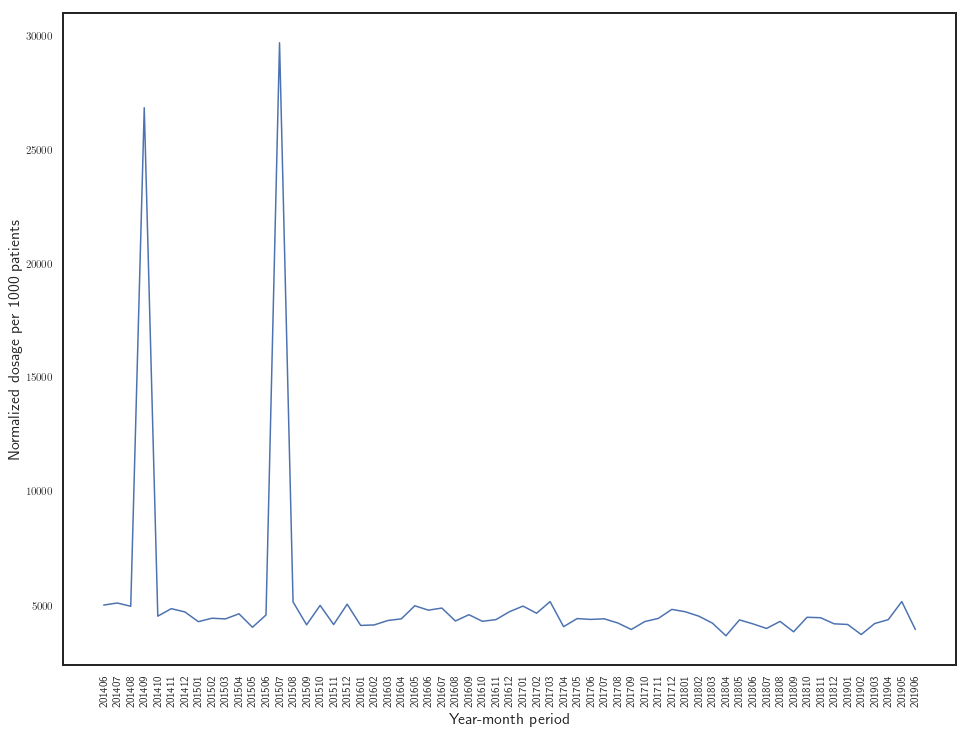

In [358]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
sns.lineplot(y=series_data['Dosage_per_1000'],x=np.arange(0,len(series_data),1))
ax = plt.gca()
plt.xticks(np.arange(0,len(series_data),1),series_data['Period'],rotation=90)
plt.xlabel("Year-month period",fontsize=16)
plt.ylabel("Normalized dosage per 1000 patients",fontsize=16)

In [359]:
openpresc_spending = pd.read_csv('scratchpad/spending-040702.csv')

In [360]:
ome_opioid = pd.read_csv('scratchpad/OME_opioid.csv')

In [361]:
ome_opioid.head()

,date,org_id,org_name,numerator,denominator,ratio,percentile,10th percentile,20th percentile,30th percentile,40th percentile,50th percentile,60th percentile,70th percentile,80th percentile,90th percentile
0,2014-08-01,NaN,NaN,1.831611e+09,56539.123,32395.457017,NaN,14846.195648,21672.320544,28617.975171,31547.082191,34284.246640,37611.583920,40939.060340,45823.301795,50300.034344
1,2014-09-01,NaN,NaN,1.896908e+09,56539.123,33550.364076,NaN,15260.395766,22754.097654,29728.158423,32457.742369,34854.164001,38017.869252,42690.365309,47030.823813,51568.303969
2,2014-10-01,NaN,NaN,1.984375e+09,56799.084,34936.741788,NaN,15488.160212,23061.937329,31039.987500,33784.618469,36451.085267,40191.286105,44410.456119,49107.445030,54609.361905
3,2014-11-01,NaN,NaN,1.775248e+09,56799.084,31254.871871,NaN,14650.793467,21383.152493,27935.469527,30161.346536,32800.130015,35947.637421,39878.731805,43573.317953,48683.393590
4,2014-12-01,NaN,NaN,2.031017e+09,56799.084,35757.922887,NaN,15666.824884,24135.373387,31639.929290,34584.155601,37251.108253,40700.544114,44880.142042,50239.886850,55887.424741


In [362]:
# openpresc_spending

In [368]:
openprescribe = {}
scale = 1000.0/56938269.0
for index , row in openpresc_spending.iterrows():
    comps = row['date'].split('-')
    date = str(comps[0]+comps[1])
    openprescribe[date] = {}
    openprescribe[date]['cost'] = 0
    openprescribe[date]['presc'] = 0
    openprescribe[date]['items'] = 0
    openprescribe[date]['cost'] = float(row['actual_cost'])*scale
    openprescribe[date]['items'] = float(row['items'])*scale
    openprescribe[date]['dose'] = float(row['quantity'])*scale
    
for index , row in ome_opioid.iterrows():
    comps = row['date'].split('-')
    date = str(comps[0]+comps[1])
    openprescribe[date]['OME'] = row['40th percentile']

In [369]:
openprescribe

{'201408': {u'OME': 31547.08219071221,
  u'cost': 406.15460736960586,
  u'dose': 2982.332041039042,
  u'items': 32.092633515079285,
  u'presc': 0},
 '201409': {u'OME': 32457.74236931987,
  u'cost': 416.8939025877306,
  u'dose': 3101.1228318163307,
  u'items': 33.386789471945484,
  u'presc': 0},
 '201410': {u'OME': 33784.61846911496,
  u'cost': 439.54278975358386,
  u'dose': 3245.3447434448703,
  u'items': 34.91804431216551,
  u'presc': 0},
 '201411': {u'OME': 30161.346535505487,
  u'cost': 391.9778042426966,
  u'dose': 2911.7980913680394,
  u'items': 31.33126509342952,
  u'presc': 0},
 '201412': {u'OME': 34584.15560061456,
  u'cost': 451.19186482469286,
  u'dose': 3306.580921875233,
  u'items': 35.23459766576325,
  u'presc': 0},
 '201501': {u'OME': 31907.11113081708,
  u'cost': 416.6473622512128,
  u'dose': 3084.863082156572,
  u'items': 33.04988074013982,
  u'presc': 0},
 '201502': {u'OME': 29654.707626867472,
  u'cost': 387.8211938617242,
  u'dose': 2866.4815398585442,
  u'items': 30

In [370]:
Ours = {}
for index , row in series_data.iterrows():
    date = str(int(row['Period']))
    Ours[date] = {}
    Ours[date]['cost'] = 0
    Ours[date]['presc'] = 0
    Ours[date]['items'] = 0
    Ours[date]['presc_ome'] = 0
    Ours[date]['presc_dosage'] = 0
    Ours[date]['cost'] = float(row['Total_cost_per_1000'])
    Ours[date]['items'] = float(row['Drugs_count'])
    Ours[date]['dose'] = float(row['Impact_per_1000'])
    Ours[date]['presc_ome'] = float(row['Prescribed_ome'])
    Ours[date]['presc_dosage'] = float(row['Prescribed_dosage'])

In [371]:
xticks = sorted(list(set(openprescribe.keys()).intersection(Ours.keys())))

In [372]:

x1_cost = [openprescribe[k]['cost'] for k in xticks]
x2_cost = [Ours[k]['cost'] for k in xticks]

x1_items = [openprescribe[k]['items'] for k in xticks]
x2_items = [Ours[k]['items'] for k in xticks]

x1_dose = [openprescribe[k]['OME'] for k in xticks]
x2_dose = [Ours[k]['dose'] for k in xticks]
x2_ome = [Ours[k]['presc_ome'] for k in xticks]
x2_presc_dosage = [Ours[k]['presc_dosage'] for k in xticks]

In [373]:
len(x1_items) , len(x2_items)

(59, 59)

In [374]:
monthLabels = ['Aug 2014','','','','', 'Jan 2015','','','','','' ,'July 2015','','','','','', 'Jan 2016' ,'','','','', '', 'July 2016','','','','', '', 'Jan 2017' ,'','','','', '','July 2017','','','','', '', 'Jan 2018' ,'','','','', '', 'July 2018', '','','','', '', 'Jan 2019' ,'','','','', 'June 2019']

In [375]:
diff = []
for i in range(len(x2_items)):
    diff.append((x2_items[i]/x1_items[i]))
np.mean(diff)

new_x2_items = [k/np.mean(diff) for k in x2_items]

In [376]:
diff_2 = []
for i in range(len(x2_cost)):
    diff_2.append((x2_cost[i]/x1_cost[i]))
np.mean(diff_2)

new_x2_costs = [k/np.mean(diff_2) for k in x2_cost]

In [377]:
diff_3 = []
for i in range(len(x2_dose)):
    diff_3.append((x2_dose[i]/x1_dose[i]))
np.mean(diff_3)

new_x2_dose = [k/np.mean(diff_3) for k in x2_dose]

In [378]:
diff_4 = []
for i in range(len(x2_presc_dosage)):
    diff_4.append((x2_presc_dosage[i]/x1_dose[i]))
np.mean(diff_4)

new_x2_presc_dose = [k/np.mean(diff_4) for k in x2_presc_dosage]

In [379]:
print np.mean(diff_4)

6.238875642469392


In [380]:
print np.mean(diff)

117.92080108559693


In [381]:
print np.mean(diff_2)

1.0224327501707817


In [382]:
sns.xkcd_rgb["amber"]

'#feb308'

In [383]:
from matplotlib import rc, rcParams
rc('axes', linewidth=2)
rc('font', weight='bold')
rc('text', usetex=True)

Text(0,0.5,u'Prescriptions per 1000 patients $\\widetilde n(a)$')

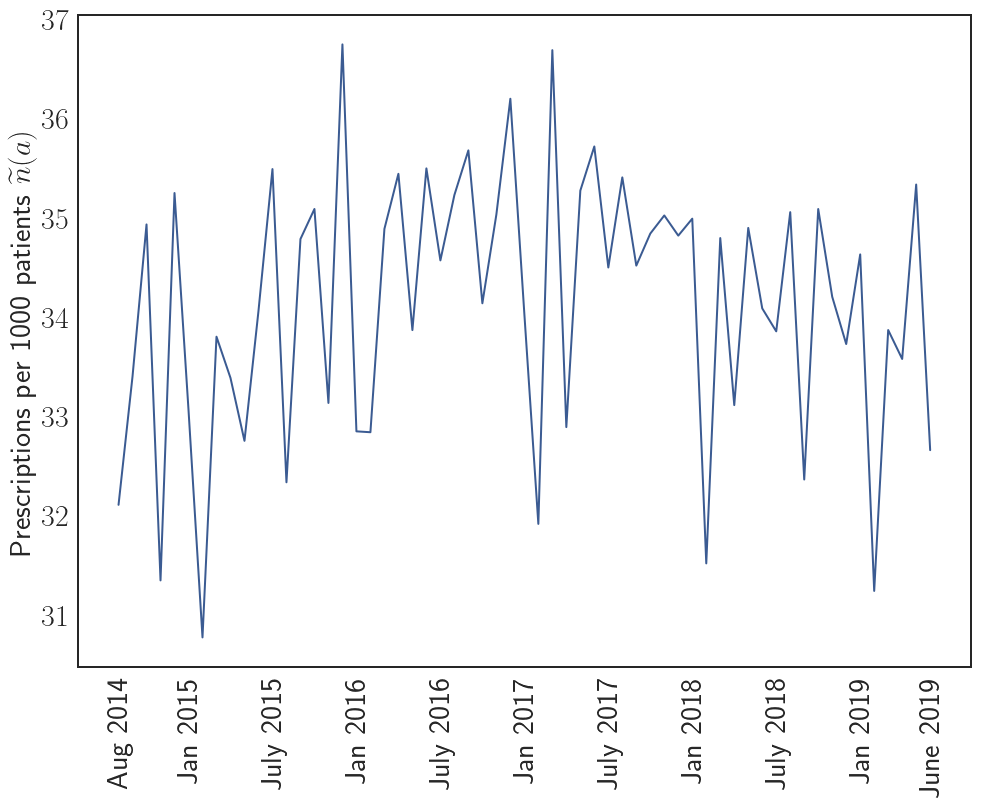

In [399]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")

# sns.lineplot(y=x1_items,x=np.arange(0,len(xticks),1))
# sns.lineplot(y=new_x2_items,x=np.arange(0,len(xticks),1))
# sns.lineplot(y=x2_items,x=np.arange(0,len(xticks),1))
plt.plot(np.arange(0,len(xticks),1),x1_items,color=sns.xkcd_rgb["denim blue"],linewidth =2 )
# plt.plot(np.arange(0,len(xticks),1),x2_items,color=sns.xkcd_rgb["denim blue"],linewidth = 2)
# plt.plot(np.arange(0,len(xticks),1),new_x2_items,linestyle = 'dashed',color=sns.xkcd_rgb["denim blue"],linewidth = 2)


ax = plt.gca()

plt.xticks(np.arange(0,len(xticks),1),monthLabels,rotation=90,fontsize= 30)
plt.yticks(fontsize= 30)
# plt.legend(['OpenPrescribing', 'Impact (adjusted)'], fontsize = 20)
# plt.xlabel("Year and month  (YYYYMM) ",fontsize=30)
plt.ylabel("Prescriptions per 1000 patients $\widetilde n(a)$",fontsize=30)



Text(0,0.5,u'Cost per 1000 patients $\\widetilde c(a)$ (GBP)')

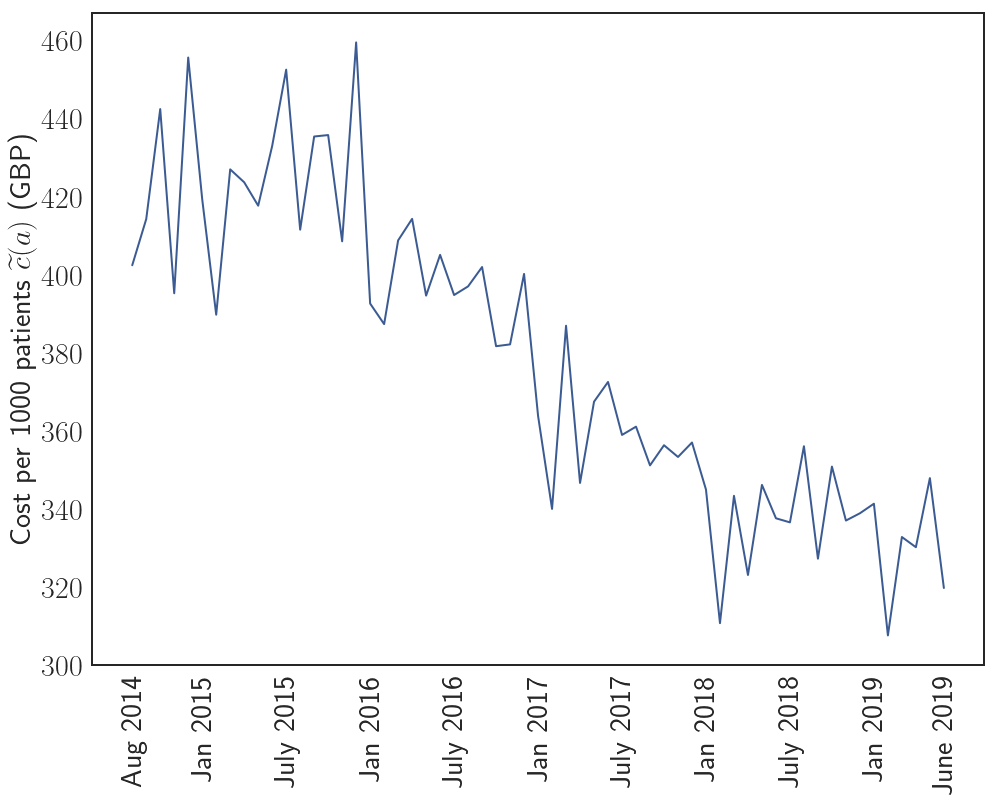

In [400]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
# sns.lineplot(y=x1_cost,x=np.arange(0,len(xticks),1))
# sns.lineplot(y=x2_cost,x=np.arange(0,len(xticks),1))

# plt.plot(np.arange(0,len(xticks),1),x1_cost,color=sns.xkcd_rgb["pale red"],linewidth =2 )
plt.plot(np.arange(0,len(xticks),1),x2_cost,color=sns.xkcd_rgb["denim blue"],linewidth = 2)


ax = plt.gca()
plt.xticks(np.arange(0,len(xticks),1),monthLabels,rotation=90,fontsize= 30)
plt.yticks(fontsize= 30)
# plt.legend(['OpenPrescribing', 'Ours'], fontsize = 20)
# plt.xlabel("Year and month  (YYYYMM) ",fontsize=30)
plt.ylabel("Cost per 1000 patients $\widetilde c(a)$ (GBP)",fontsize=30)

Text(0,0.5,u'OME/Adjusted Impact')

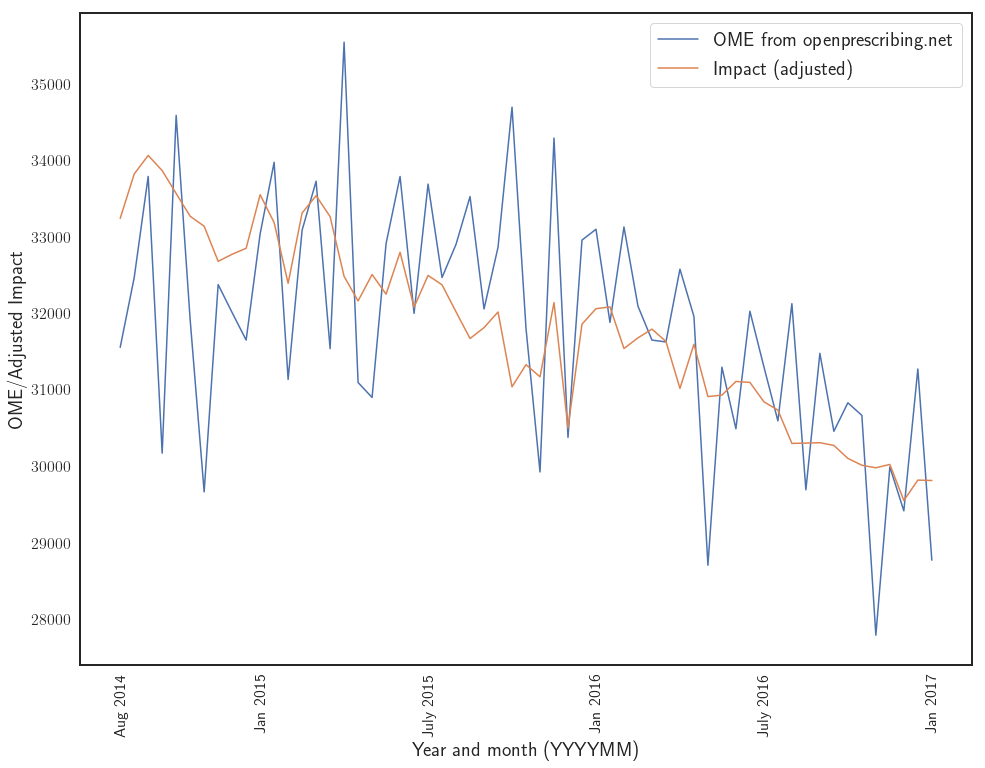

In [386]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
sns.lineplot(y=x1_dose,x=np.arange(0,len(xticks),1))
sns.lineplot(y=new_x2_dose,x=np.arange(0,len(xticks),1))
ax = plt.gca()
plt.xticks(np.arange(0,len(xticks),2),monthLabels,rotation=90,fontsize= 16)
plt.yticks(fontsize= 16)
plt.legend(['OME from openprescribing.net', 'Impact (adjusted)'], fontsize = 20)
plt.xlabel("Year and month  (YYYYMM) ",fontsize=20)
plt.ylabel("OME/Adjusted Impact",fontsize=20)

Text(0,0.5,u'OME/Adjusted Impact')

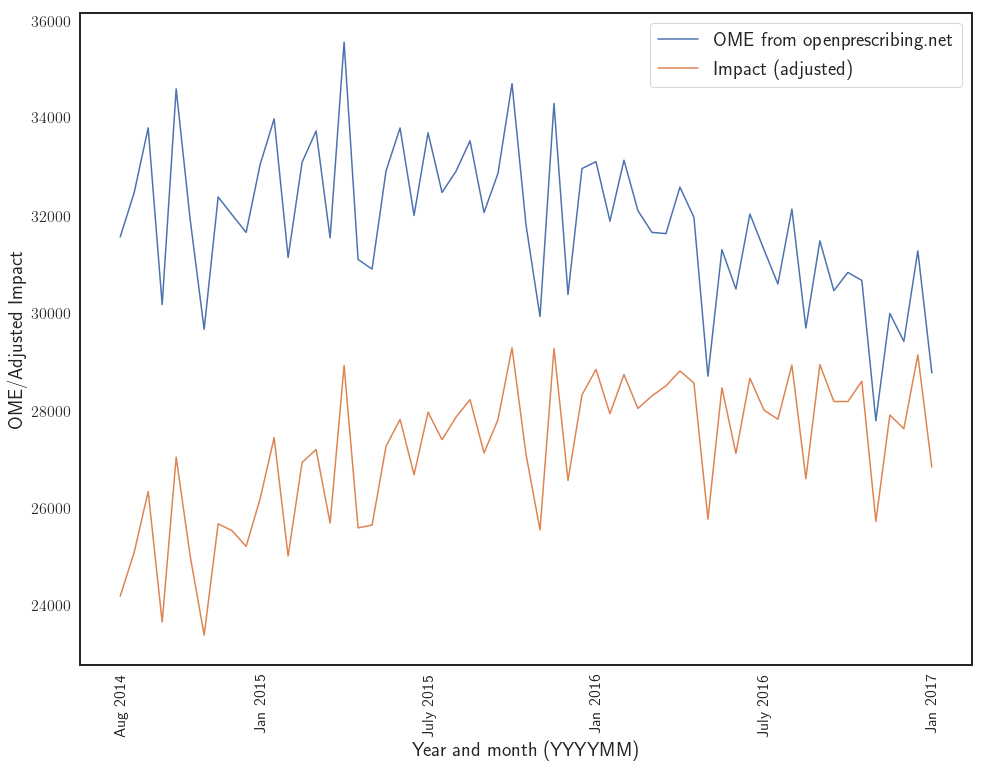

In [389]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
sns.lineplot(y=x1_dose,x=np.arange(0,len(xticks),1))
sns.lineplot(y=x2_ome,x=np.arange(0,len(xticks),1))
ax = plt.gca()
plt.xticks(np.arange(0,len(xticks),2),monthLabels,rotation=90,fontsize= 16)
plt.yticks(fontsize= 16)
plt.legend(['OME from openprescribing.net', 'Impact (adjusted)'], fontsize = 20)
plt.xlabel("Year and month  (YYYYMM) ",fontsize=20)
plt.ylabel("OME/Adjusted Impact",fontsize=20)

In [297]:
# fig, ax = plt.subplots()
# fig.set_size_inches(16, 12)
# sns.set_style("white")
# sns.lineplot(y=series_data['Prescriptions_per_1000'],x=np.arange(0,len(series_data),1))
# sns.lineplot(y=items_series['Drugs_count'],x=np.arange(0,len(series_data),1))
# ax = plt.gca()
# plt.xticks(np.arange(0,len(series_data),1),series_data['Period'],rotation=90,fontsize= 11)
# plt.yticks(fontsize= 12)
# plt.legend(['Total prescriptions per 1000 patients', 'Total prescribed items per 1000 patients'], fontsize = 16)
# plt.xlabel("Year and month  (YYYYMM) ",fontsize=16)
# plt.ylabel("Per 1000 patients",fontsize=16)

Text(0,0.5,u'Opioid Cost per 1000 patients')

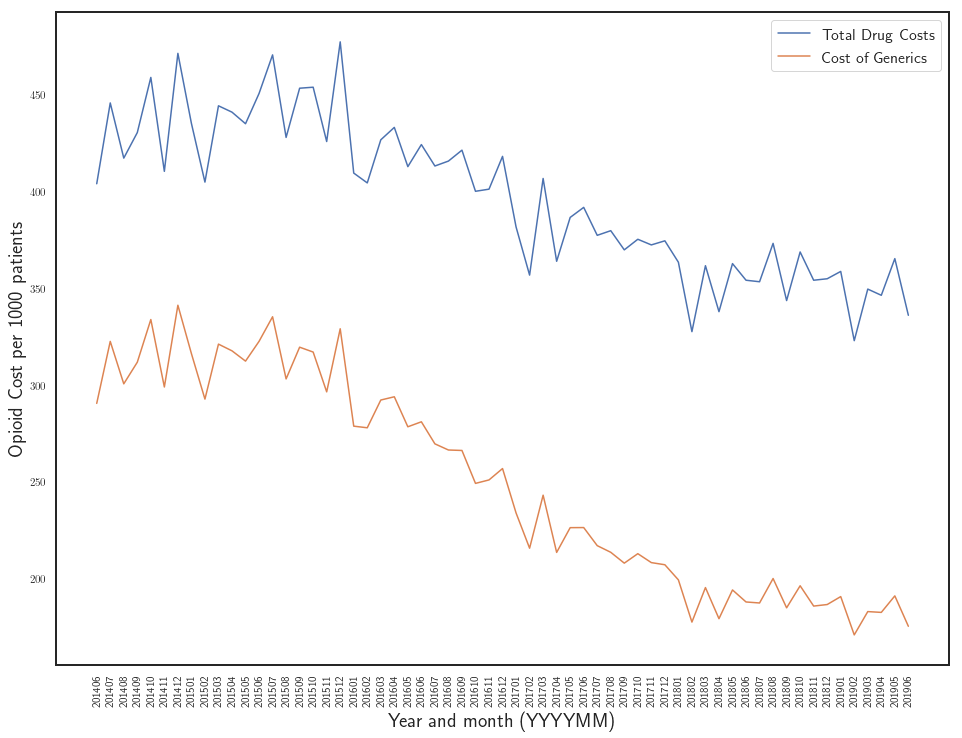

In [298]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
sns.lineplot(y=series_data['Total_cost_per_1000'],x=np.arange(0,len(series_data),1))
sns.lineplot(y=series_data['Generic_cost_per_1000'],x=np.arange(0,len(series_data),1))
ax = plt.gca()
plt.xticks(np.arange(0,len(series_data),1),series_data['Period'],rotation=90)
plt.legend(['Total Drug Costs', 'Cost of Generics'], fontsize = 16)
plt.xlabel("Year and month  (YYYYMM)",fontsize=20)
plt.ylabel("Opioid Cost per 1000 patients",fontsize=20)

In [214]:
fentalyl_series_data = pd.read_csv('Fentanyl_timeSeries.csv')

Text(0,0.5,u'Cost per 1000 patients')

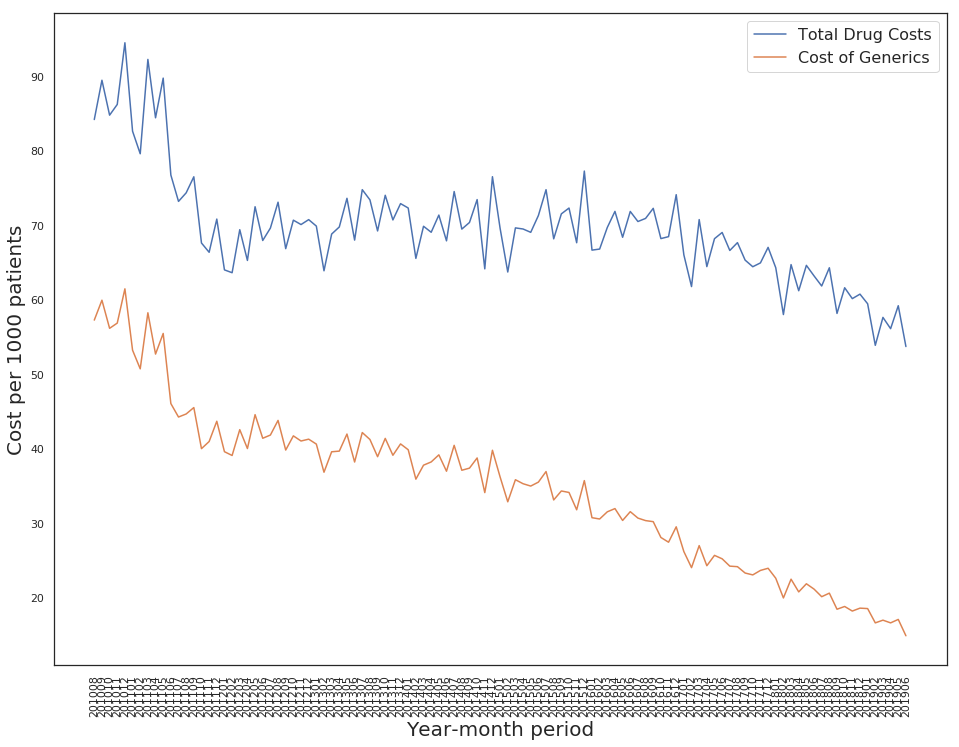

In [215]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
sns.lineplot(y=fentalyl_series_data['Total_cost_per_1000'],x=np.arange(0,len(series_data),1))
sns.lineplot(y=fentalyl_series_data['Generic_cost_per_1000'],x=np.arange(0,len(series_data),1))
ax = plt.gca()
plt.xticks(np.arange(0,len(series_data),1),series_data['Period'],rotation=90)
plt.legend(['Total Drug Costs', 'Cost of Generics'], fontsize = 16)
plt.xlabel("Year-month period",fontsize=20)
plt.ylabel("Cost per 1000 patients",fontsize=20)

Text(0,0.5,u'Items per 1000 patients')

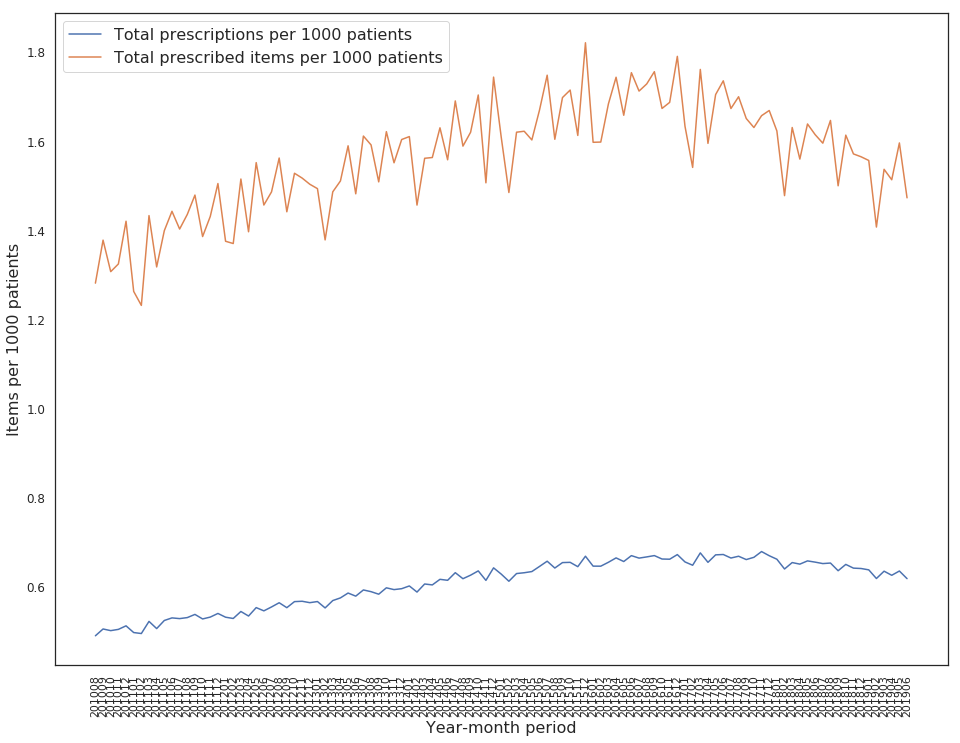

In [167]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.set_style("white")
sns.lineplot(y=fentalyl_series_data['Prescriptions_per_1000'],x=np.arange(0,len(series_data),1))
sns.lineplot(y=fentalyl_series_data['Drugs_count'],x=np.arange(0,len(series_data),1))
ax = plt.gca()
plt.xticks(np.arange(0,len(series_data),1),series_data['Period'],rotation=90,fontsize= 11)
plt.yticks(fontsize= 12)
plt.legend(['Total prescriptions per 1000 patients', 'Total prescribed items per 1000 patients'], fontsize = 16)
plt.xlabel("Year-month period",fontsize=16)
plt.ylabel("Items per 1000 patients",fontsize=16)